In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
import networkx as nx
from networkx.algorithms.community import girvan_newman
import enchant
from matplotlib import cm
import matplotlib.colors as mcolors

In [2]:
def clean_message(message):
    message = message.strip().split(" ")
    message = [word for word in message if word]  # Remove empty strings
    message = [''.join(char for char in word if char.isalnum()).lower() for word in message]
    message = [word for word in message if word]  # Remove empty strings again after cleaning
    return ' '.join(message)

In [3]:
def df_preprocessing(df):
    words = {}
    englishDictionary = enchant.Dict("en_GB")
    slangThreshold = 5

    df['body'] = df['body'].apply(clean_message)
    for message in df['body']:
        messageCopy = clean_message(message).split(" ")
        for word in messageCopy:
            word = ''.join(char for char in word if char.isalnum()).lower()
            if word:
                if word in words.keys():
                    words[word] += 1
                else:
                    words[word] = 1
                    
    wordsToRemove = []
    for word in list(words.keys()):
        if words[word] < slangThreshold:
            if not englishDictionary.check(word):
                wordsToRemove.append(word)
                
    for word in wordsToRemove:
        del words[word]
        df['body'] = df['body'].str.replace(r'\b' + word + r'\b', '', regex=True)
                
    return df, words

In [4]:
def create_adj_matrix(df, words):
    adj_matrix = pd.DataFrame(np.zeros((len(words), len(words)), dtype=int), index=words.keys(), columns=words.keys())

    for message in df['body']:
        messageCopy = clean_message(message).split(" ")
        # print(messageCopy)
        for word1 in messageCopy:
            word1 = ''.join(char for char in word1 if char.isalnum()).lower()
            if word1 and word1 in words.keys():
                for word2 in messageCopy:
                    word2 = ''.join(char for char in word2 if char.isalnum()).lower()
                    if word2 and word2 in words.keys():
                        adj_matrix.at[word1, word2] += 1 
                        
    return adj_matrix

In [ ]:
#Load messages
df = pd.read_csv('messages.csv')
df_me = df[df['is_from_me'] == 1].copy()
df_them = df[df['is_from_me'] == 0].copy()

#Preprocess messages into unique words
df_me, words_me = df_preprocessing(df_me)
df_them, words_them = df_preprocessing(df_them)
df_combined, words_combined = df_preprocessing(df)

#Create Co-occurrence matrices
adj_matrix_me = create_adj_matrix(df_me, words_me)
adj_matrix_them = create_adj_matrix(df_them, words_them)
adj_matrix_combined = create_adj_matrix(df_combined, words_combined)

In [ ]:
def layered_layout(G, root):
    pos = {}
    layers = nx.single_source_shortest_path_length(G, root)  # Get shortest paths
    max_layer = max(layers.values())
    
    # Group nodes by layer
    layer_nodes = {i: [] for i in range(max_layer + 1)}
    for node, layer in layers.items():
        layer_nodes[layer].append(node)
    
    # Calculate positions
    for layer, nodes in layer_nodes.items():
        num_nodes = len(nodes)
        if num_nodes > 0:
            np.random.shuffle(nodes)
            # Central alignment for x-axis
            x_spacing = 1 / (num_nodes + 1)
            start_x = -0.5 + x_spacing  # Start x-coordinates centrally
            for i, node in enumerate(nodes):
                x = start_x + i * x_spacing
                if layer == 3:
                    y = np.random.uniform(-layer+1.8, -layer+1.6)
                else:
                    y = np.random.uniform(-layer+1.8, -layer+1)  # Keep the layer y-coordinates distinct
                pos[node] = (x, y)
    return pos, layers


In [ ]:
def adj_matrix_co_occurrence_shortest_path(end_node, adj_matrix, colourPallette="flare", *, title="", layout="layered"):
    #G2 is graph with all co-occurrence edges, G is graph with shortest path edges
    G = nx.Graph()
    G2 = nx.Graph()

    # Add nodes to the graphs
    for word in adj_matrix.index:
        G.add_node(word)
        G2.add_node(word)
        
    # Add edges based on co-occurrence
    for word1 in adj_matrix.index:
        for word2 in adj_matrix.columns:
            if word1 != word2 and adj_matrix.at[word1, word2] > 0:
                G2.add_edge(word1, word2, weight=adj_matrix.at[word1, word2])

    # Add edges based on shortest paths
    for word in adj_matrix.index:
        if nx.has_path(G2, source=word, target=end_node):
            shortest_path = nx.shortest_path(G2, source=word, target=end_node)
            if len(shortest_path) > 4:
                continue
            for i in range(len(shortest_path)-1):
                G.add_edge(shortest_path[i], shortest_path[i+1], weight=adj_matrix.at[shortest_path[i], shortest_path[i+1]])

    # Remove isolated nodes
    degrees = dict(G.degree(G.nodes()))
    for node, degree in degrees.items():
        if degree == 0:
            G.remove_node(node)
    
    # Set node sizes based on degrees
    node_size = [max(degrees[n] * 5, 30) for n in G.nodes()]

    # -------Plotting graph-------
    plt.figure(figsize=(15, 15))
    
    if layout == "layered":
        # Get node positions using the layered layout
        pos, layers = layered_layout(G, end_node)
        
        # Get colours for layers
        unique_layers = sorted(set(layers.values()))
        cmap = plt.get_cmap(colourPallette, len(unique_layers))
        layer_color_map = {layer: cmap(i) for i, layer in enumerate(unique_layers)}
        node_colors = [layer_color_map[layers[node]] for node in G.nodes()]
        
        # Create edge colors by averaging the node colors for each edge
        edge_colors = [
            mcolors.to_rgba_array([layer_color_map[layers[u]], layer_color_map[layers[v]]]).mean(axis=0)
            for u, v in G.edges()
        ]

        # Modify edge opacity
        edge_colors_with_opacity = [
            (*color[:3], 0.15) #Alpha 0.15
            for color in edge_colors
        ]
    
    elif layout == "spring_layout":
        pos = nx.spring_layout(G)
        node_colors = "red"
        edge_colors_with_opacity = "grey"
    
    elif layout == "kamada_kawai_layout":
        pos = nx.kamada_kawai_layout(G)
        node_colors = "red"
        edge_colors_with_opacity = "grey"
    
    # Draw nodes (no alpha applied here, only node colors)
    nx.draw(
        G,
        pos,
        with_labels=False,
        font_size=5,
        node_size=node_size,
        node_color=node_colors,
        edge_color="white",  # Temporarily set edge color to white so it is not visible
        alpha=0.9
    )
    
    # Draw edges again with reduced opacity
    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=G.edges(),
        edge_color=edge_colors_with_opacity,  # Set edge color with reduced opacity
        width=1,
    )

    # Draw plot
    plt.title(f"{title}")
    plt.show()


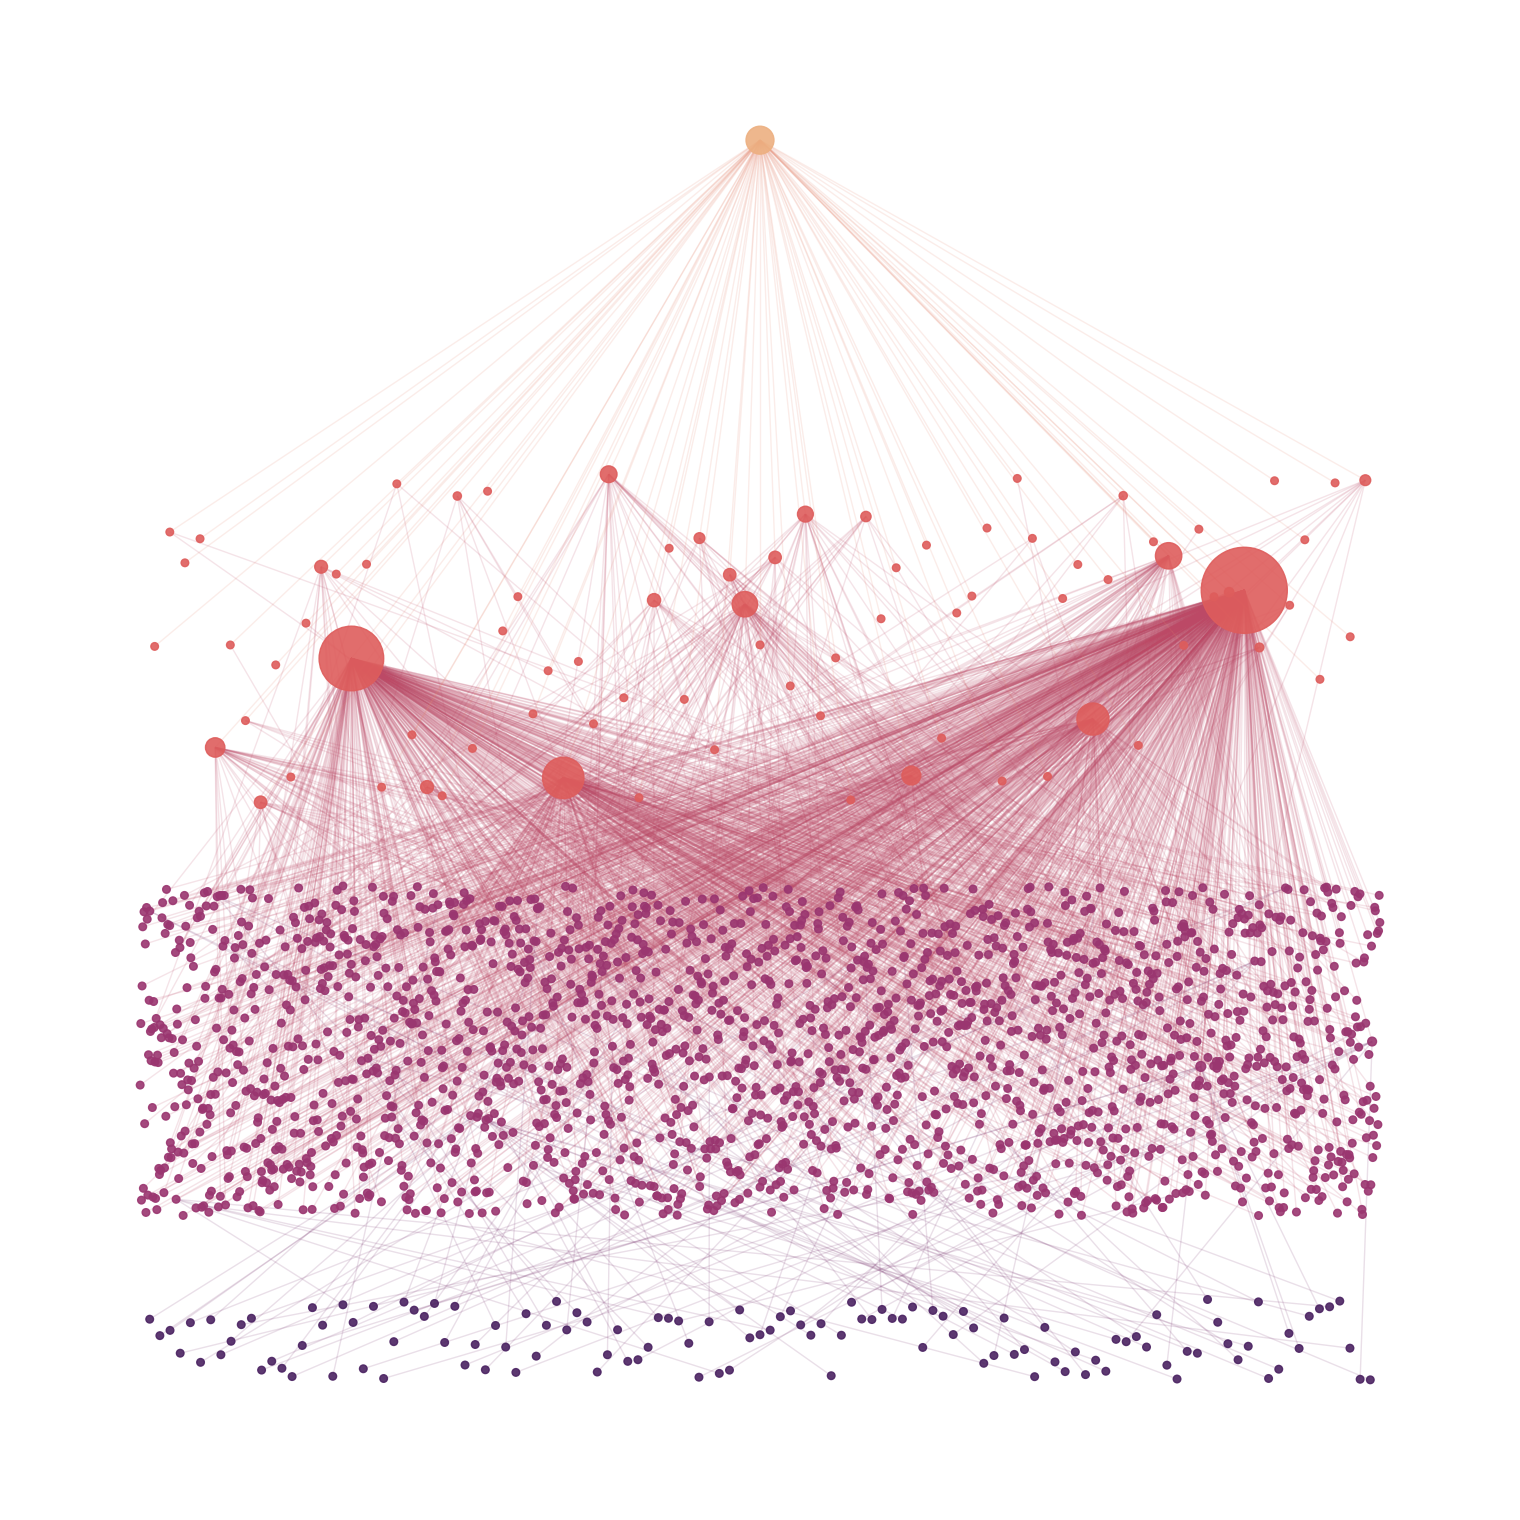

In [ ]:
acceptedColours = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']
adj_matrix_co_occurrence_shortest_path(end_node="love", adj_matrix=adj_matrix_me, colourPallette="flare")

In [ ]:
def adj_matrix_co_occurrence(adj_matrix, *, layout="spring_layout", title=""):
    G = nx.Graph()

    # Add nodes
    for word in adj_matrix.index:
        G.add_node(word)

    # Add edges
    for word1 in adj_matrix.index:
        for word2 in adj_matrix.columns:
            if word1 != word2 and adj_matrix.at[word1, word2] > 0:
                G.add_edge(word1, word2, weight=adj_matrix.at[word1, word2])


    degrees = dict(G.degree(G.nodes()))
    
    node_size = [degrees[n] * 10 for n in G.nodes()]
   
    # Draw the graph with Kamada-Kawai layout and color-coded clusters
    plt.figure(figsize=(10, 8))
    if layout == "spring_layout":
        pos = nx.spring_layout(G)
    else:
        pos = nx.kamada_kawai_layout(G)
    
    for node, degree in degrees.items():
        if degree == 0:
            #Move isolated nodes to a random location
            pos[node] = (np.random.uniform(-1, 1), np.random.uniform(-1, 1))

    # Draw the graph
    nx.draw(G, pos, with_labels=False, font_size=5, node_size=80, node_color='red', edge_color='grey', alpha=0.5)
    plt.title(f"{title}")
    plt.show()

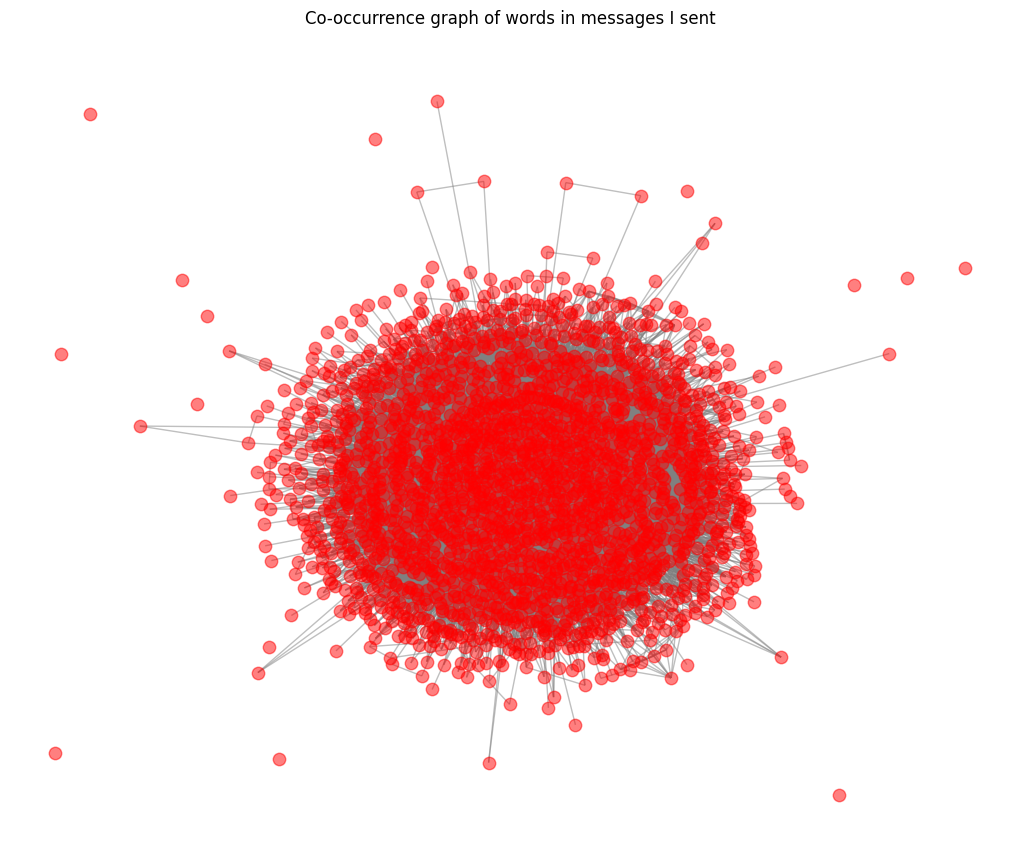

In [ ]:
adj_matrix_co_occurrence(adj_matrix_me, layout="kamada_kawai", title="Co-occurrence graph of words in messages I sent")